# Feature Engineering: IBM AML HI-Small Dataset

**Project**: Explainable Anomaly Detection in Dynamic Financial Networks  
**Dataset**: IBM Transactions for Anti-Money Laundering (HI-Small)  
**Objective**: Extract meaningful features for AML Analysis


## 1. Setup

In [65]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd


## 2. Data Loading & Overview

In [64]:
file_path = "Dataset/HI-Small_Trans.csv"
df = pd.read_csv(
        file_path,
        parse_dates=['Timestamp'],
        dtype={
            'From Bank': str,
            'To Bank': str,
            'Account': str,
            'Payment Format': 'category',
            'Receiving Currency': 'category',
            'Payment Currency': 'category',
            'Is Laundering': np.int8
        }
    )

    # The data has duplicate account column, need rename to indicate directio of transaction
df.columns = [
    'timestamp', 'from_bank', 'from_account', 'to_bank', 'to_account',
    'amount_received', 'receiving_currency', 'amount_paid',
    'payment_currency', 'payment_format', 'is_laundering'
]

df.insert(0, 'transaction_id', range(len(df)))

print(f"\nLoaded {len(df):,} transactions")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Laundering transactions: {df['is_laundering'].sum():,} ({df['is_laundering'].mean()*100:.3f}%)")
trans_df = df


Loaded 5,078,345 transactions
Date range: 2022-09-01 00:00:00 to 2022-09-18 16:18:00
Laundering transactions: 5,177 (0.102%)


## 3. Feature Effectiveness Functions

### 3.1 Comparison Function
**Objective**: Used to evaluate if feature differs in laundering and non-laundering data

In [100]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, chi2_contingency
from scipy.stats.contingency import association

def compare_feature_by_class(df, label_col, feature_cols):
    results = []

    for feat in feature_cols:
        x = df[feat]
        y = df[label_col]

        laundering = df[df[label_col] == 1][feat].dropna()
        non_laundering = df[df[label_col] == 0][feat].dropna()

        # --- Type ---
        if x.nunique() == 2:
            ftype = 'binary'
        elif x.dtype == 'object' or x.nunique() < 20:
            ftype = 'categorical'
        else:
            ftype = 'numeric'

        summary = {
            "feature_name": feat,
            "feature_type": ftype,
            "laundering_count": len(laundering),
            "nonlaundering_count": len(non_laundering),
            "missing_rate": x.isna().mean(),
        }

        # --- Numeric features ---
        if ftype == 'numeric':
            mean_l = laundering.mean()
            mean_nl = non_laundering.mean()
            std_l = laundering.std()
            std_nl = non_laundering.std()
            median_l = laundering.median()
            median_nl = non_laundering.median()

            summary.update({
                "laundering_mean": mean_l,
                "nonlaundering_mean": mean_nl,
                "laundering_std": std_l,
                "nonlaundering_std": std_nl,
                "laundering_median": median_l,
                "nonlaundering_median": median_nl,
                "diff_mean": abs(mean_l - mean_nl),
            })

        # --- Binary features ---
        elif ftype == 'binary':
            prop_l = laundering.mean()
            prop_nl = non_laundering.mean()
            diff = abs(prop_l - prop_nl)

            summary.update({
                "laundering_rate_1": prop_l,
                "nonlaundering_rate_1": prop_nl,
                "diff_prop": diff,
            })

        # --- Categorical features ---
        elif ftype == 'categorical':
            ctab = pd.crosstab(x, y)
            if ctab.shape[0] > 1 and ctab.shape[1] == 2:
                try:
                    chi2, pval, _, _ = chi2_contingency(ctab)
                except:
                    chi2, pval = np.nan, np.nan
                try:
                    cramer_v = association(ctab, method='cramer')
                except:
                    cramer_v = np.nan
            else:
                chi2, pval, cramer_v = np.nan, np.nan, np.nan

            top_l = laundering.value_counts(normalize=True).head(3).to_dict()
            top_nl = non_laundering.value_counts(normalize=True).head(3).to_dict()

            summary.update({
                "laundering_top_values": top_l,
                "nonlaundering_top_values": top_nl,
                "num_categories": x.nunique(),
                "cramers_v": cramer_v,
                "p_value": pval
            })

        results.append(summary)

    return pd.DataFrame(results)

### 3.2 Comparison Visualization

In [ ]:
def visualize_feature_comparison(comp_df, percent=0):
    import matplotlib.pyplot as plt

    n = len(comp_df)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))
    if n == 1:
        axes = [axes]
    for i, (_, row) in enumerate(comp_df.iterrows()):
        feat = row['feature_name']
        ftype = row['feature_type']
        ax = axes[i]
        if ftype == 'numeric':
            # Exclude outliers based on percent
            def trim_outliers(series, percent):
                if percent <= 0:
                    return series.dropna()
                lower = percent / 2
                upper = 1 - lower
                q_low = series.quantile(lower)
                q_high = series.quantile(upper)
                return series[(series >= q_low) & (series <= q_high)].dropna()

            # Trim outliers for the whole dataset first
            trimmed = trim_outliers(trans_df[feat], percent)
            nl = trimmed[trans_df['is_laundering'] == 0]
            l = trimmed[trans_df['is_laundering'] == 1]
            ax.boxplot([nl, l], labels=['Non-Laundering', 'Laundering'])
            ax.set_title(f'Boxplot of {feat}')
            ax.set_ylabel(feat)
        elif ftype == 'binary':
            ax.bar(['Non-Laundering', 'Laundering'], [row['nonlaundering_rate_1'], row['laundering_rate_1']])
            ax.set_title(f'Proportion of {feat} = 1')
            ax.set_ylabel('Proportion')
        elif ftype == 'categorical':
            top_nl = row['nonlaundering_top_values']
            top_l = row['laundering_top_values']
            labels = list(set(top_nl.keys()).union(top_l.keys()))
            nl_vals = [top_nl.get(k, 0) for k in labels]
            l_vals = [top_l.get(k, 0) for k in labels]
            x = range(len(labels))
            ax.bar(x, nl_vals, width=0.4, label='Non-Laundering', align='center')
            ax.bar([i+0.4 for i in x], l_vals, width=0.4, label='Laundering', align='center')
            ax.set_xticks([i+0.2 for i in x])
            ax.set_xticklabels(labels, rotation=45)
            ax.set_title(f'Top Values of {feat}')
            ax.set_ylabel('Proportion')
            ax.legend()
    plt.tight_layout()
    plt.show()

## 4. Features - Transactions

### Feature 1: different_amount / different_currency / different_bank
- **Type**: Binary
- **Description**: Indicates if the transaction involves different amounts, currencies, or banks.

In [102]:
trans_df['different_amount'] = trans_df['amount_received'] != trans_df['amount_paid']
trans_df['different_currency'] = trans_df['receiving_currency'] != trans_df['payment_currency']
trans_df['different_bank'] = trans_df['from_bank'] != trans_df['to_bank']   
cp_df = compare_feature_by_class(trans_df,'is_laundering',['different_amount', 'different_currency', 'different_bank'])
cp_df

,feature_name,feature_type,laundering_count,nonlaundering_count,missing_rate,laundering_rate_1,nonlaundering_rate_1,diff_prop
0,different_amount,binary,5177,5073168,0.0,0.000000,0.014223,0.014223
1,different_currency,binary,5177,5073168,0.0,0.000000,0.014226,0.014226
2,different_bank,binary,5177,5073168,0.0,0.980104,0.863763,0.116341


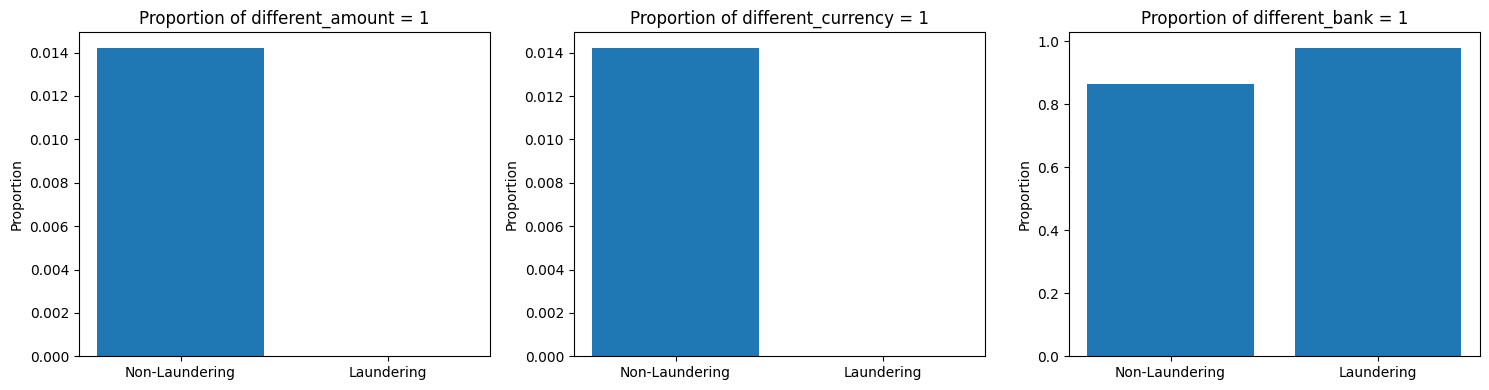

In [103]:
visualize_feature_comparison(cp_df)

### Feature 2: time_sin / time_cos
- **Type**: Numeric (Cyclical for Sine and Cosine)
- **Description**: Represents the time of day the transaction occurred, encoded as sine and cosine to capture cyclical nature.
- **Outcome**: Only keep time_cos since it is more significant

In [104]:
trans_df['minutes'] = trans_df['timestamp'].dt.hour * 60 + trans_df['timestamp'].dt.minute
# Encode as sine and cosine
trans_df['time_sin'] = np.sin(2 * np.pi * trans_df['minutes']/1440)
trans_df['time_cos'] = np.cos(2 * np.pi * trans_df['minutes']/1440)
trans_df.drop(columns=['minutes'], inplace=True)
cp_df = compare_feature_by_class(trans_df,'is_laundering',['time_sin', 'time_cos'])
cp_df

,feature_name,feature_type,laundering_count,nonlaundering_count,missing_rate,laundering_mean,nonlaundering_mean,laundering_std,nonlaundering_std,laundering_median,nonlaundering_median,diff_mean
0,time_sin,numeric,5177,5073168,0.0,-0.063033,0.006064,0.704804,0.676161,-0.108867,0.043619,0.069098
1,time_cos,numeric,5177,5073168,0.0,-0.166969,0.086579,0.686722,0.731624,-0.304864,0.147809,0.253548


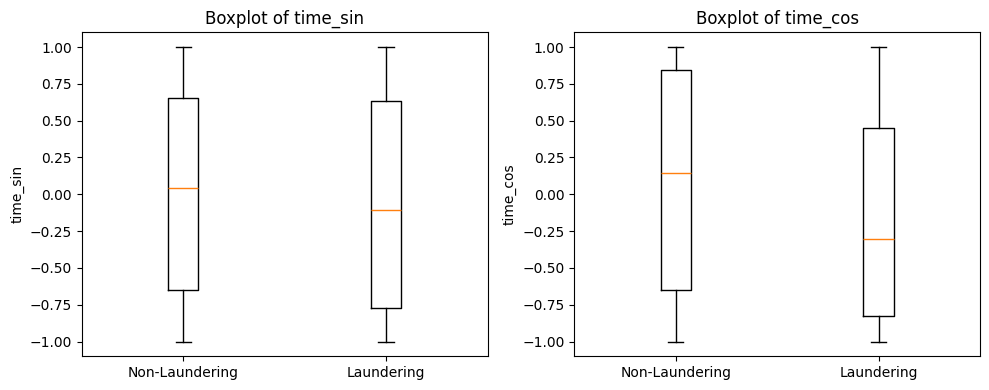

In [105]:
visualize_feature_comparison(cp_df)
trans_df.drop(columns=['time_sin'], inplace=True) # Time_cos is more important

### Alternative: time_0am

Observation from: https://www.kaggle.com/code/shirmilaiddamalgoda/aml-preprocessing-and-feature-engineering#EVALUATION

Main differences across time happens for time at 0am / not at 0am

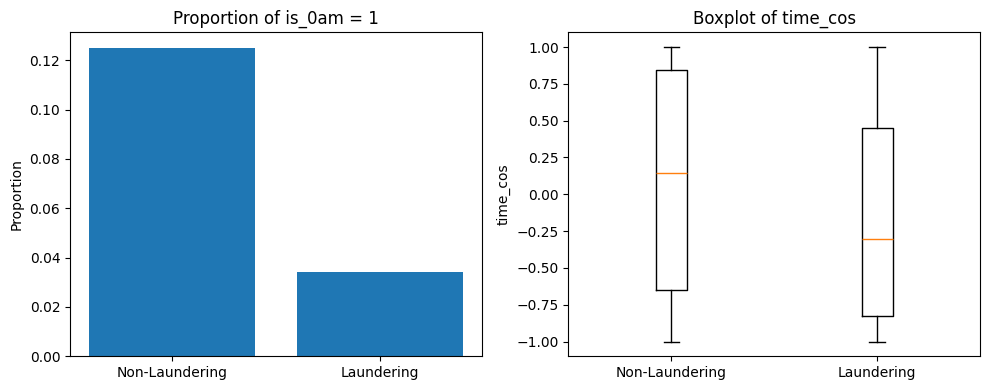

In [106]:
trans_df['is_0am'] = (trans_df['timestamp'].dt.hour == 0).astype(int)
cp_df = compare_feature_by_class(trans_df,'is_laundering',['is_0am', 'time_cos'])
visualize_feature_comparison(cp_df)


### Feature 3: time_since_last_incoming_txn (Not very significant)
- **Type**: Numeric
- **Description**: Time elapsed since the last incoming transaction to the receiver account.
- **Justification**: Accounts with High frequency are more possible to be laundering

In [108]:
# Compute time since last incoming transaction for each transaction's from_account
def compute_time_since_last_incoming(df):
    # Sort by timestamp for correct order
    df_sorted = df.sort_values('timestamp')
    # Map from_account to its last timestamp
    last_incoming = {}
    time_since_last = np.full(len(df_sorted), np.nan)
    for idx, row in enumerate(df_sorted.itertuples()):
        from_acc = row.from_account
        curr_time = row.timestamp
        # If from_account has appeared as from_account before, compute gap
        if from_acc in last_incoming:
            gap = (curr_time - last_incoming[from_acc]).total_seconds() / 60.0  # minutes
            time_since_last[idx] = gap
        # Update last incoming time for from_account
        last_incoming[from_acc] = curr_time
    # Fill missing with mean
    mean_gap = np.nanmean(time_since_last)
    time_since_last = np.where(np.isnan(time_since_last), mean_gap, time_since_last)
    # Assign to original dataframe order
    trans_df['time_since_last_incoming_txn'] = pd.Series(time_since_last, index=df_sorted.index).reindex(trans_df.index).values
# def compute_time_since_last_incoming(df):
#     # Sort by timestamp for correct order
#     df_sorted = df.sort_values('timestamp')
#     # Map to_account to its last timestamp
#     last_incoming = {}
#     time_since_last = np.full(len(df_sorted), np.nan)
#     for idx, row in enumerate(df_sorted.itertuples()):
#         to_acc = row.to_account
#         curr_time = row.timestamp
#         # If to_account has appeared as to_account before, compute gap
#         if to_acc in last_incoming:
#             gap = (curr_time - last_incoming[to_acc]).total_seconds() / 60.0  # minutes
#             time_since_last[idx] = gap
#         # Update last incoming time for to_account
#         last_incoming[to_acc] = curr_time
#     # Fill missing with mean
#     mean_gap = np.nanmean(time_since_last)
#     time_since_last = np.where(np.isnan(time_since_last), mean_gap, time_since_last)
#     # Assign to original dataframe order
#     trans_df['time_since_last_incoming_txn'] = pd.Series(time_since_last, index=df_sorted.index).reindex(trans_df.index).values
compute_time_since_last_incoming(trans_df)
 

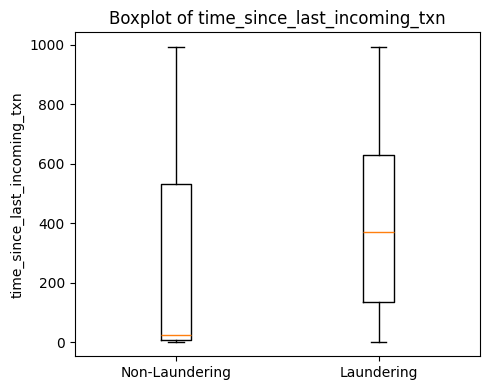

In [107]:
cp_df = compare_feature_by_class(trans_df,'is_laundering',['time_since_last_incoming_txn'])
visualize_feature_comparison(cp_df, 0.3)

## 5 Features: Account-Level

In [170]:
def compute_account_statistics(transactions_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate per-account metrics.

    Returns:
        DataFrame with account-level statistics
    """
    print("Computing account statistics...")

    #aggregate outgoing transactions
    outgoing = transactions_df.groupby('from_account').agg({
        'transaction_id': 'count',
        'amount_paid': ['sum', 'mean', 'std', 'min', 'max'],
        'to_account': 'nunique',
        'is_laundering': 'sum'
    })
    outgoing.columns = ['num_outgoing', 'total_sent', 'avg_sent', 'std_sent', 'min_sent', 'max_sent', 'num_recipients', 'laundering_sent']

    #aggregate incoming transactions
    incoming = transactions_df.groupby('to_account').agg({
        'transaction_id': 'count',
        'amount_received': ['sum', 'mean', 'std', 'min', 'max'],
        'from_account': 'nunique',
        'is_laundering': 'sum'
    })
    incoming.columns = ['num_incoming', 'total_received', 'avg_received', 'std_received', 'min_received', 'max_received', 'num_senders', 'laundering_received']

    #combine
    account_stats = outgoing.join(incoming, how='outer').fillna(0)
    account_stats['total_transactions'] = account_stats['num_outgoing'] + account_stats['num_incoming']
    account_stats['net_flow'] = account_stats['total_received'] - account_stats['total_sent']
    account_stats['net_flow_imbalance_ratio'] = (account_stats['total_received'] - account_stats['total_sent']) / (account_stats['total_received'] + account_stats['total_sent'])

    print(f"  Computed statistics for {len(account_stats):,} accounts")

    return account_stats

In [171]:
acc_df = compute_account_statistics(trans_df)

Computing account statistics...
  Computed statistics for 515,080 accounts
  Computed statistics for 515,080 accounts


In [172]:
print(f'Number of accounts with laundering_sent: {len(acc_df[acc_df['laundering_sent'] > 0])}')
print(f'Number of accounts with laundering_received: {len(acc_df[acc_df['laundering_received'] > 0])}')
print(f'Number of accounts with both laundering_sent and laundering_received: {len(acc_df[(acc_df['laundering_sent'] > 0) & (acc_df['laundering_received'] > 0)])}')

Number of accounts with laundering_sent: 3376
Number of accounts with laundering_received: 3984
Number of accounts with both laundering_sent and laundering_received: 1003


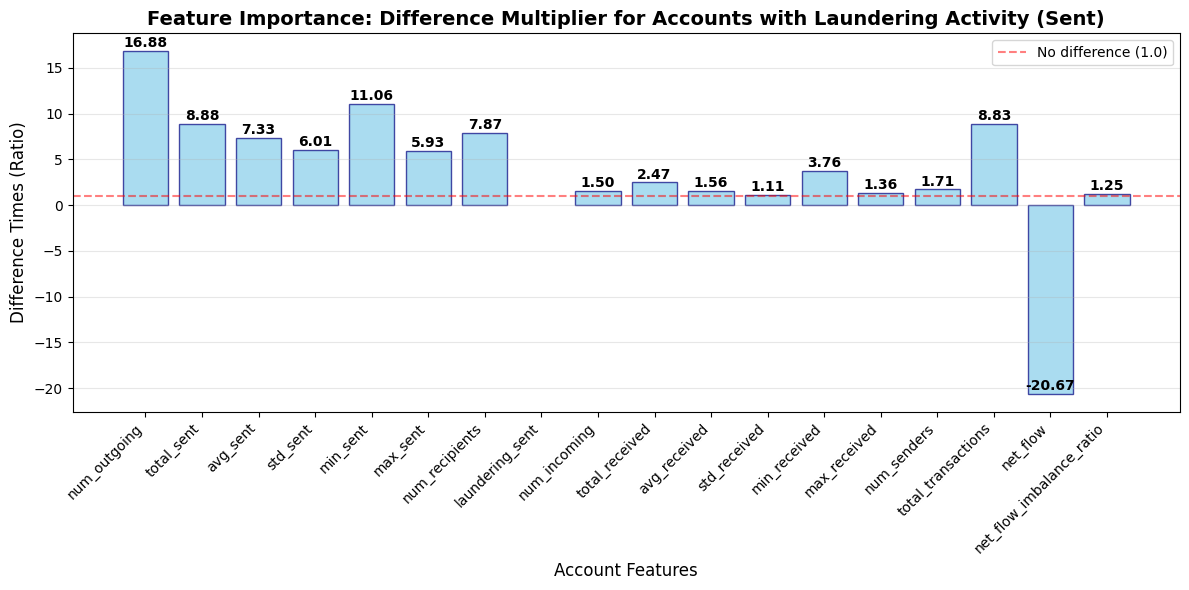

,mean_laundering_sent_pos,mean_laundering_sent_zero,diff_times
num_outgoing,1.507533e+02,8.929776e+00,16.882088
total_sent,3.753976e+08,4.227503e+07,8.879890
avg_sent,3.550639e+07,4.845843e+06,7.327185
std_sent,4.422158e+07,7.355709e+06,6.011872
min_sent,7.279336e+06,6.580913e+05,11.061286
max_sent,1.132282e+08,1.910410e+07,5.926905
num_recipients,1.484893e+01,1.887040e+00,7.868902
laundering_sent,1.533472e+00,0.000000e+00,inf
num_incoming,1.478199e+01,9.826855e+00,1.504244
total_received,2.399491e+07,5.927609e+07,2.470361


In [173]:
# Compare account statistics for laundering_sent > 0 vs laundering_sent == 0

sent_pos_stats = acc_df[acc_df['laundering_sent'] > 0].describe()
sent_zero_stats = acc_df[acc_df['laundering_sent'] == 0].describe()

# Safe ratio calculation - avoid division by zero
def safe_ratio(numerator, denominator):
    """Calculate ratio safely, handling division by zero"""
    ratio = np.where(denominator != 0, numerator / denominator, np.inf)
    ratio[abs(ratio) < 1] = 1/ratio[abs(ratio) < 1]
    return ratio

sent_times = safe_ratio(sent_pos_stats.loc['mean'], sent_zero_stats.loc['mean'])

# Compare account statistics for laundering_received > 0 vs laundering_received == 0
recv_pos_stats = acc_df[acc_df['laundering_received'] > 0].describe()
recv_zero_stats = acc_df[acc_df['laundering_received'] == 0].describe()

recv_times = safe_ratio(recv_pos_stats.loc['mean'], recv_zero_stats.loc['mean'])

# Combine results into DataFrames
sent_diff_df = pd.DataFrame({
    'mean_laundering_sent_pos': sent_pos_stats.loc['mean'],
    'mean_laundering_sent_zero': sent_zero_stats.loc['mean'],
    'diff_times': sent_times
})

recv_diff_df = pd.DataFrame({
    'mean_laundering_received_pos': recv_pos_stats.loc['mean'],
    'mean_laundering_received_zero': recv_zero_stats.loc['mean'],
    'diff_times': recv_times
})

# Create bar chart for diff_times, excluding laundering_sent
plt.figure(figsize=(12, 6))

# Filter out laundering_sent from the data
sent_chart_data = sent_diff_df[sent_diff_df.index != 'laundering_sent']
sent_chart_data = sent_diff_df[sent_diff_df.index != 'laundering_received']

# Create bar chart
bars = plt.bar(range(len(sent_chart_data)), sent_chart_data['diff_times'], 
               color='skyblue', edgecolor='navy', alpha=0.7)

# Customize the chart
plt.title('Feature Importance: Difference Multiplier for Accounts with Laundering Activity (Sent)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Account Features', fontsize=12)
plt.ylabel('Difference Times (Ratio)', fontsize=12)
plt.xticks(range(len(sent_chart_data)), sent_chart_data.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    if np.isfinite(height):  # Only show finite values
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# Add horizontal line at y=1 for reference
plt.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No difference (1.0)')
plt.legend()

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

sent_diff_df

**Observation**
- Number of Recipients / Num_Outgoing / Net_flow means a lot -> Should Add to transaction feature

In [162]:
# Add account-level features to each transaction using from_account
trans_df['num_outgoing'] = trans_df['from_account'].map(acc_df['num_outgoing'])
trans_df['total_sent'] = trans_df['from_account'].map(acc_df['total_sent'])
trans_df['avg_sent'] = trans_df['from_account'].map(acc_df['avg_sent'])
trans_df['num_recipients'] = trans_df['from_account'].map(acc_df['num_recipients'])
trans_df['net_flow'] = trans_df['from_account'].map(acc_df['net_flow'])

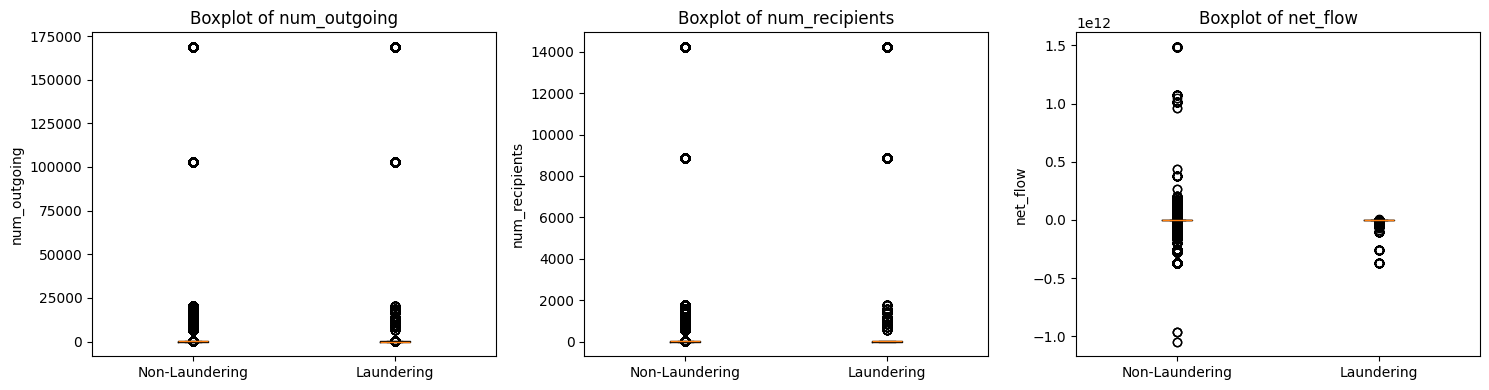

,feature_name,feature_type,laundering_count,nonlaundering_count,missing_rate,laundering_mean,nonlaundering_mean,laundering_std,nonlaundering_std,laundering_median,nonlaundering_median,diff_mean
0,num_outgoing,numeric,5177,5073168,0.0,1.174102e+04,8.253273e+03,3.914219e+04,3.316442e+04,16.00,42.00,3.487752e+03
1,num_recipients,numeric,5177,5073168,0.0,9.989672e+02,7.004674e+02,3.312422e+03,2.806871e+03,4.00,4.00,2.984997e+02
2,net_flow,numeric,5177,5073168,0.0,-6.701287e+09,-4.866448e+09,3.191553e+10,2.858368e+10,-23567.51,-46403.63,1.834839e+09


In [174]:
cp_df = compare_feature_by_class(trans_df,'is_laundering',['num_outgoing', 'num_recipients', 'net_flow'])
visualize_feature_comparison(cp_df)
cp_df

## 6. Transaction feature within account

Observe Features Related to how a laundering transaction differs from others in the same account

#### Sending side

### Feature 1: Daily net flow
- **Type**: Numeric

In [156]:
sent_laundering_accs = set(acc_df[acc_df['laundering_sent'] > 0].index)
sent_laundering_trans = trans_df['from_account'].isin(sent_laundering_accs).astype(int)
print("Proportion of laundering transactions:", sent_laundering_trans.mean())
print("Proportion of non-laundering transactions:", 1 - sent_laundering_trans.mean())

Proportion of laundering transactions: 0.10021827977421778
Proportion of non-laundering transactions: 0.8997817202257822


In [157]:
sent_df = trans_df[trans_df['from_account'].isin(sent_laundering_accs)]

In [163]:
trans_df['value_ratio'] = trans_df['amount_paid'] / trans_df['avg_sent']

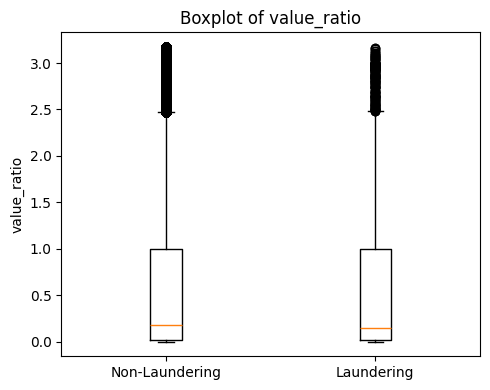

,feature_name,feature_type,laundering_count,nonlaundering_count,missing_rate,laundering_mean,nonlaundering_mean,laundering_std,nonlaundering_std,laundering_median,nonlaundering_median,diff_mean
0,value_ratio,numeric,5177,5073168,0.0,1.613016,0.999374,5.115366,7.434827,0.195768,0.176818,0.613641


In [169]:
cp = compare_feature_by_class(trans_df, 'is_laundering', ['value_ratio'])
visualize_feature_comparison(cp, 0.1)
cp

In [177]:
trans_df['date'] = trans_df['timestamp'].dt.date

In [1]:
def compute_account__daily_statistics(transactions_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate per-account metrics.

    Returns:
        DataFrame with account-level statistics
    """
    print("Computing account statistics...")

    #aggregate outgoing transactions
    outgoing = transactions_df.groupby(['from_account','date']).agg({
        'transaction_id': 'count',
        'amount_paid': ['sum', 'mean', 'std', 'min', 'max'],
        'to_account': 'nunique',
        'is_laundering': 'sum'
    })
    outgoing.columns = ['num_outgoing', 'total_sent', 'avg_sent', 'std_sent', 'min_sent', 'max_sent', 'num_recipients', 'laundering_sent']

    #aggregate incoming transactions
    incoming = transactions_df.groupby(['to_account','date']).agg({
        'transaction_id': 'count',
        'amount_received': ['sum', 'mean', 'std', 'min', 'max'],
        'from_account': 'nunique',
        'is_laundering': 'sum'
    })
    incoming.columns = ['num_incoming', 'total_received', 'avg_received', 'std_received', 'min_received', 'max_received', 'num_senders', 'laundering_received']

    #combine
    account_stats = outgoing.join(incoming, how='outer').fillna(0)
    account_stats['total_transactions'] = account_stats['num_outgoing'] + account_stats['num_incoming']
    account_stats['net_flow'] = account_stats['total_received'] - account_stats['total_sent']
    account_stats['net_flow_imbalance_ratio'] = (account_stats['total_received'] - account_stats['total_sent']) / (account_stats['total_received'] + account_stats['total_sent'])

    print(f"  Computed statistics for {len(account_stats):,} accounts")

    return account_stats
daily_df = compute_account__daily_statistics(trans_df)

NameError: name 'pd' is not defined